This is a short exercise to practice the use of random forest for statistical analysis.

Based on the guide in

 https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html

Written by Shing Chi Leung at 23 Feb 2021

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 

# for blobs and circle analysis
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# for digit classifications
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount("gdrive")

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


Now I will read the temperature data and briefly examine its features. The file contains the comparison between the temperature forecast and the actual temperature. 

In [ ]:
# fetch the file and check the global statistics

file_path = "gdrive/MyDrive/Colab Notebooks/temps.csv"
df = pd.read_csv(file_path)

print(df.head(5))

print("Shape of the data {}\n".format(df.shape))
df.describe()

   year  month  day  week  ...  forecast_noaa  forecast_acc  forecast_under  friend
0  2016      1    1   Fri  ...             43            50              44      29
1  2016      1    2   Sat  ...             41            50              44      61
2  2016      1    3   Sun  ...             43            46              47      56
3  2016      1    4   Mon  ...             44            48              46      53
4  2016      1    5  Tues  ...             46            46              46      41

[5 rows x 12 columns]
Shape of the data (348, 12)



,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,77.000000,82.000000,79.000000,95.000000


I will separate the week days into hot vectors. 

In [ ]:
# convert categorical data into hot_vector

df = pd.get_dummies(df)
df.head(5)

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,43,50,44,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,41,50,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,43,46,47,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,44,48,46,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,46,46,46,41,0,0,0,0,0,1,0


Then I will remove the target label and put it in another array, and build the training and test sets. 

In [ ]:
labels = np.array(df["actual"])

# remove the actual result columne
df = df.drop("actual", axis=1)

# extract the column name
feature_list = list(df.columns)

# convert to numpy array
df = np.array(df)

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(df, labels, test_size=0.25)

print("train_x shape: {}".format(train_x.shape))
print("train_y shape: {}".format(train_y.shape))

train_x shape: (261, 17)
train_y shape: (261,)


In [ ]:
print(df[:5,:])

print(feature_list)

[[2.016e+03 1.000e+00 1.000e+00 4.500e+01 4.500e+01 4.560e+01 4.300e+01
  5.000e+01 4.400e+01 2.900e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00]
 [2.016e+03 1.000e+00 2.000e+00 4.400e+01 4.500e+01 4.570e+01 4.100e+01
  5.000e+01 4.400e+01 6.100e+01 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00]
 [2.016e+03 1.000e+00 3.000e+00 4.500e+01 4.400e+01 4.580e+01 4.300e+01
  4.600e+01 4.700e+01 5.600e+01 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  0.000e+00 0.000e+00 0.000e+00]
 [2.016e+03 1.000e+00 4.000e+00 4.400e+01 4.100e+01 4.590e+01 4.400e+01
  4.800e+01 4.600e+01 5.300e+01 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00]
 [2.016e+03 1.000e+00 5.000e+00 4.100e+01 4.000e+01 4.600e+01 4.600e+01
  4.600e+01 4.600e+01 4.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00]]
['year', 'month', 'day', 'temp_2', 'temp_1', 'average', 'forecast_noaa', 'forecast_acc', 'forecast_under', 'friend

Then I will build and train the random forest classifier. 

In [ ]:
# set up the baseline for our verification

baseline_pred = test_x[:,feature_list.index("average")]
baseline_error = abs(baseline_pred - test_y)
print('Average baseline error: ', round(np.mean(baseline_error), 2))

Average baseline error:  4.66


In [ ]:
# build the random tree regressor 

rf = RandomForestRegressor(n_estimators=1000, random_state=42)
rf.fit(train_x, train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

I use the trained model to predict. 

In [ ]:
preds = rf.predict(test_x)

errors = abs(preds - test_y)
print("Mean absolute error = {}".format(round(np.mean(errors),2)))

Mean absolute error = 3.8


In [ ]:
# performance statistics 

mape = 100 * (errors / test_y)

accuracy = 100 - np.mean(mape)
print("Accuracy = {}".format(accuracy))

Accuracy = 93.52503839148567


The accuracy is high that it exceeds 90%. Then I want to see how a typical tree looks like. 

In [ ]:
#visualizing the random tree

from sklearn.tree import export_graphviz
import pydot

# get one of the trees
tree = rf.estimators_[5]

# export the image to dot file
export_graphviz(tree, out_file = "tree.dot", feature_names = feature_list, rounded=True, precision=1)

# use the dot file to create a graph
(graph, ) = pydot.graph_from_dot_file("tree.dot")
graph.write_png("gdrive/MyDrive/Colab Notebooks/tree.png")


I can also study which parameters are the most important. 

In [ ]:
# get numerical feature importances
importances = list(rf.feature_importances_)

feature_importances = [(feature, round(importance,2)) for feature, importance in zip(feature_list, importances)]

#sort the feature according to the importances
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: temp_1               Importance: 0.59
Variable: average              Importance: 0.23
Variable: forecast_acc         Importance: 0.06
Variable: day                  Importance: 0.02
Variable: temp_2               Importance: 0.02
Variable: forecast_noaa        Importance: 0.02
Variable: friend               Importance: 0.02
Variable: month                Importance: 0.01
Variable: forecast_under       Importance: 0.01
Variable: year                 Importance: 0.0
Variable: week_Fri             Importance: 0.0
Variable: week_Mon             Importance: 0.0
Variable: week_Sat             Importance: 0.0
Variable: week_Sun             Importance: 0.0
Variable: week_Thurs           Importance: 0.0
Variable: week_Tues            Importance: 0.0
Variable: week_Wed             Importance: 0.0


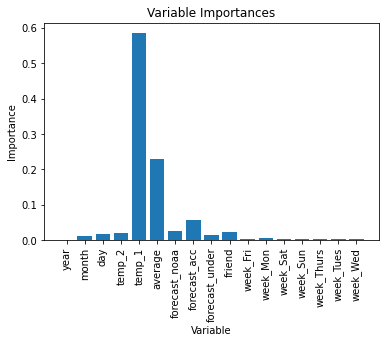

In [ ]:
# visualization of the importance

import matplotlib.pyplot as plt

x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation="vertical")

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances');


It shows clearly that the temp_1 and the average temp has the strongest impact to how the actual temperature depends on the background temperature. 

Text(0.5, 1.0, 'Actual and Predicted Values')

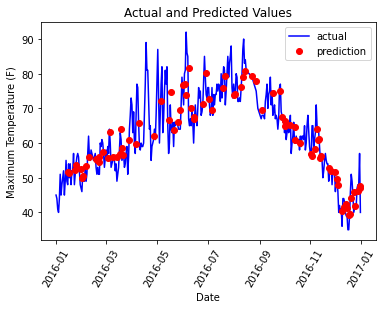

In [ ]:
# I copy the code directly just for quick visualization

# Use datetime for creating date objects for plotting
import datetime

# Dates of training values
months = df[:, feature_list.index('month')]
days = df[:, feature_list.index('day')]
years = df[:, feature_list.index('year')]

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

# Dates of predictions
months = test_x[:, feature_list.index('month')]
days = test_x[:, feature_list.index('day')]
years = test_x[:, feature_list.index('year')]

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': preds})

# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')

plt.xticks(rotation = '60'); 
plt.legend()

# Graph labels
plt.xlabel('Date')
plt.ylabel('Maximum Temperature (F)')
plt.title('Actual and Predicted Values')

We can see that the prediction does follow very well theglobal trend of the data. 

# Decision Trees for Blobs

In this part I will use sklearn datasets to generate blobs of data and use Random Forest to classify the blobs. 

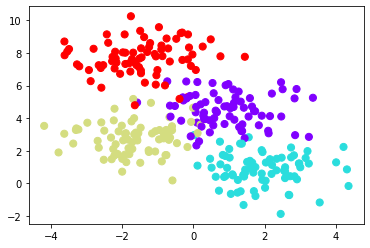

In [ ]:
x, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
plt.scatter(x[:,0], x[:,1], c=y, s=50, cmap="rainbow")

In [ ]:
tree = DecisionTreeClassifier().fit(x, y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: The following kwargs were not used by contour: 'clim'


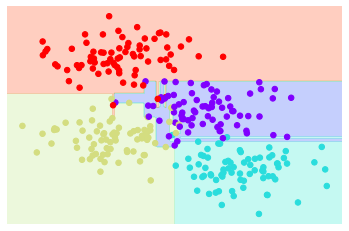

In [ ]:
def visualize_classifer(model, x, y, ax=None, cmap="rainbow"):
  ax=ax or plt.gca()

  # plot the training points
  ax.scatter(x[:,0], x[:,1], c=y, s=30, cmap=cmap, clim=(y.min(), y.max()), zorder=3)
  ax.axis("tight")
  ax.axis("off")

  xlim = ax.get_xlim()
  ylim = ax.get_ylim()

  # fit the estimator
  model.fit(x, y)
  xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                       np.linspace(*ylim, num=200))
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

  # create a color plot
  n_classes = len(np.unique(y))
  contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes+1) - 0.5, cmap=cmap, clim=(y.min(), y.max()), zorder=1)

  ax.set(xlim=xlim, ylim=ylim)

visualize_classifer(tree, x, y)

With a high number of trees, the classification criteria contains many high order features. This suggests some overfitting exists. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: The following kwargs were not used by contour: 'clim'


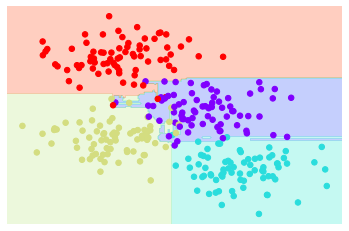

In [ ]:
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8)
bag.fit(x, y)
visualize_classifer(bag, x, y)

# Random Tree Regression

In this part I will use random tree to idenfity the time series of oscillating function. 

<ErrorbarContainer object of 3 artists>

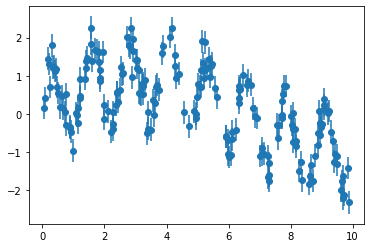

In [ ]:
rng = np.random.RandomState(42)

x = 10 * rng.rand(200)

def model(x, sigma=0.3):
  fast_oscillation = np.sin(5*x)
  slow_oscillation = np.sin(0.5*x)

  noise = sigma * rng.randn(len(x))

  return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt="o")

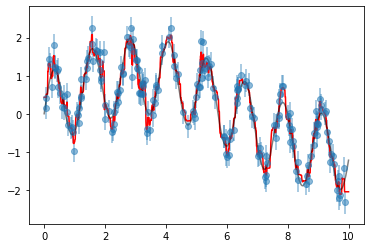

In [ ]:
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
y_test = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt="o", alpha=0.5)
plt.plot(xfit, yfit, "-r")
plt.plot(xfit, y_test, "-k", alpha=0.5)

The prediction is very much similar to the original data. 

# Digit Classifications

In this part I will use random forest to identify the digits of some hand written numbers. The data comes from sklearn datasets. 

In [ ]:
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

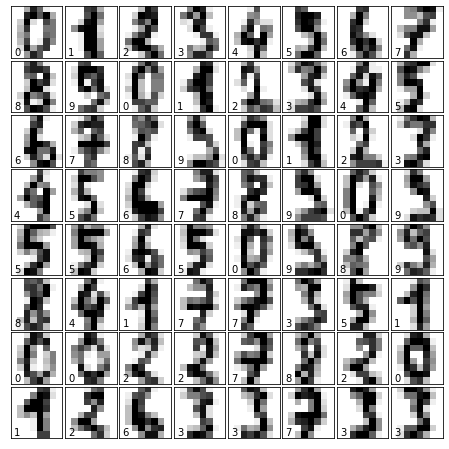

In [ ]:
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits
for i in range(64):
  ax = fig.add_subplot(8,8, i+1, xticks=[], yticks=[])
  ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation="nearest")

  # label the image with the target value
  ax.text(0, 7, str(digits.target[i]))

Then I build the training and test sets, and use the training set to train the classification model. 

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(digits.data, digits.target)
model = RandomForestClassifier(n_estimators=1000)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [ ]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        41
           1       1.00      0.98      0.99        46
           2       0.98      1.00      0.99        48
           3       1.00      0.98      0.99        48
           4       1.00      1.00      1.00        34
           5       1.00      0.98      0.99        46
           6       0.98      1.00      0.99        53
           7       1.00      1.00      1.00        44
           8       0.96      0.98      0.97        46
           9       0.93      0.98      0.96        44

    accuracy                           0.98       450
   macro avg       0.99      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



The accuray of the model is very high. Then I will visualize the confusion matrix.

Text(91.68, 0.5, 'predicted label')

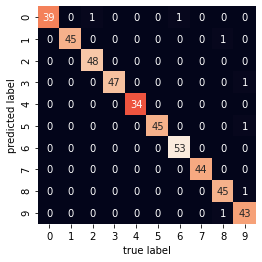

In [ ]:
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt="d", cbar=False)

plt.xlabel("true label")
plt.ylabel("predicted label")